# Supervised Facial Recognition with OpenCV
#### By James Barnden

This python notebook acompanies the tutorial on my blog, for more in depth explanations of what's going on, [click here](https://jamqes.com/uni/?p=434) to go check it out.

In [1]:
# Import opencv
import cv2
# We'll need os to handle our dataset files
import os
import numpy as np

In [2]:
def list_dirs(basePath, ordered=True):
    """
        Return a list of all immediate sub-directories within basePath.
    """
    from os import listdir
    from os.path import isdir, join
    subDirs = [x for x in listdir(basePath) if isdir(join(basePath, x))]
    if ordered: subDirs.sort()
    return subDirs

def retrieve_file_paths(basePath, extension='.csv'):
    """
        Return a list of all files/paths to datasets from a given folder with a
        particular extension.
    """
    from os import listdir
    from os.path import splitext, isfile, join
    files = [x for x in listdir(basePath)
            if isfile(join(basePath, x)) and splitext(x)[1] == extension]
 
    # Return list of full paths
    paths = []
    for f in files:
        paths.append(basePath+f)
    return paths

In [3]:
basePath = "att_faces/"
 
# Get list of subjects (each directory in this dataset represents a distinct subject)
subjectIDs = list_dirs(basePath)
 
subjectIDs
 
# Uncomment below if you're not using jupyter notebook
#print(subjectIDs)

['s1',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's2',
 's20',
 's21',
 's22',
 's23',
 's24',
 's25',
 's26',
 's27',
 's28',
 's29',
 's3',
 's30',
 's31',
 's32',
 's33',
 's34',
 's35',
 's36',
 's37',
 's38',
 's39',
 's4',
 's40',
 's5',
 's6',
 's7',
 's8',
 's9']

In [4]:
subjects = {}
for s in subjectIDs:
    # Fetch paths to all images for this subject
    imagePaths = retrieve_file_paths(basePath + s + '/', extension='.pgm')
 
    images = []
    for p in imagePaths:
        images.append(cv2.imread(p, 0))
 
    # Get integer value of subject ID
    sID = int(s.strip('s'))
    subjects[sID] = images
 
# This should print 40
print(len(subjects))
 
# Lets choose a subject
subject = subjects[6]
print('There are ', len(subject), 'images of this subject')

40
There are  10 images of this subject


In [5]:
# Display random image
from matplotlib import pyplot as plt
plt.imshow(subject[6], cmap="gray")
# Use below instead of imshow if using another IDE
# plt.imsave('subject6Test.png', cmap="gray")

In [6]:
def train_test_split(dataset, numTrain):
    # Split testing and training data
    train = {}
    test = {}
 
    for sID, imageArr in dataset.items():
        train[sID] = imageArr[:numTrain]
        test[sID] = imageArr[numTrain:]
 
    return train, test

In [7]:
import pandas as pd
def format_dataset(dataset, shuffle=False):
    from random import shuffle as shuff
 
    images = []
    labels = []
 
    for label, imageArr in dataset.items():
        if shuffle: shuff(imageArr)
        for image in imageArr:
            labels.append(label)
            images.append(image)
 
    return labels, images
 
def run_evaluation(recognizer, trainSet, testSet):
    """
        Trains a LBPH classifier on the train set, evaluates it on the test set.
        Function returns a results table and a micro weighted F1 score.
    """
 
    from sklearn.metrics import f1_score
 
    trainLabels, trainImages = format_dataset(trainSet)
    testLabels, testImages = format_dataset(testSet)
 
    # Train the recognizer with the training set
    recognizer.train(trainImages, np.array(trainLabels))
 
    # Test the recognizer
    actualLabels = []
    predictedLabels = []
    predictionConfidence = []
    for label, imageArr in testSet.items():
        for img in imageArr:
            # Get tuple with predicted label and confidence value
            labConfTup = recognizer.predict(img)
            predictedLabels.append(labConfTup[0])
            predictionConfidence.append(labConfTup[1])
            actualLabels.append(label)
 
    # Create a results table from the data
    d = {'Predicted_Label': predictedLabels, 'Actual_Label':actualLabels,
         'Confidence':predictionConfidence}
 
    # Generate an f1 score
    f1 = f1_score(actualLabels, predictedLabels, average='micro')
    return pd.DataFrame(data=d), f1

In [8]:
# Create an OpenCV LBPHFaceRecognizer
recognizer = cv2.face.LBPHFaceRecognizer_create()
 
"""
    Split dataset, where 6 images will be used as training for each subject, and 4 will be used for testing.
"""
train, test = train_test_split(subjects, 6)
 
resTable, f1 = run_evaluation(recognizer, train, test)
# Use the below for jupyter notebook
resTable.head(20)
# Uncomment below for any other IDE
#print(resTable.head(20))

,Actual_Label,Confidence,Predicted_Label
0,1,82.127054,1
1,1,84.744994,1
2,1,90.813847,1
3,1,99.501161,1
4,10,80.120322,10
5,10,72.778629,10
6,10,66.456627,10
7,10,92.662588,10
8,11,68.480766,11
9,11,70.187202,11


In [9]:
f1

0.9375

In [10]:
# Lists to keep track of values at each iteration (these will be used to generate
# a graph later)
trainingSampleSize = []
f1Score = []
 
for trainSize in range(1, 8):
    # Create a fresh recognizer
    recognizer = cv2.face.LBPHFaceRecognizer_create()
 
    # Use a training set of size "trainSize"
    train, test = train_test_split(subjects, trainSize) 
    # Evaluate the classifier
    resTable, f1 = run_evaluation(recognizer, train, test) 
 
    # Append data from this iteration to lists
    trainingSampleSize.append(trainSize)
    f1Score.append(f1)
 
# Create table of results
d = {'Training Samples':trainingSampleSize, 'F1 Score':f1Score}
df = pd.DataFrame(data=d)
 
df
# Uncomment below outside of jupyter notebook
# print(df.to_string())

,F1 Score,Training Samples
0,0.675000,1
1,0.800000,2
2,0.885714,3
3,0.900000,4
4,0.940000,5
5,0.937500,6
6,0.941667,7


In [11]:
def save_plot(plot_id, images_path="", tight_layout=True,
              img_extension="png", resolution=300):
    import os
    path = os.path.join(images_path, plot_id + "." + img_extension)
    print("Saving figure", plot_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=img_extension, dpi=resolution)

def scatter_with_trendline(dataset, xLabel, yLabel, alpha=None, save=False):
    """
        Draws a scatter plot with a trend line for the given attributes of the
        given dataset (for visualising correlations).
        
        Where dataset is a pandas dataframe and "x" and "y" are attribute labels
        from the given dataset.
    """
    
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt
    
    # Create scatter plot from given attributes
    d = dataset[[xLabel, yLabel]]
    x = d[xLabel]
    y = d[yLabel]
    
    plt.scatter(x,y,alpha=alpha)
    plt.xlabel(xLabel, fontsize=12)
    plt.ylabel(yLabel,fontsize=12)
    
    # Calculate trendline
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    # Plot trendline
    plt.plot(x, p(x), "r--")
    
    if save:
        label = "scatter_plot_" + x + "_" + y
        save_plot("scatter")
    
    plt.show()

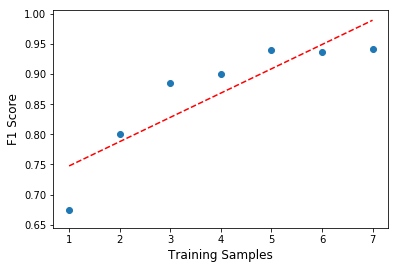

In [12]:
# Create scatter plot, plotting number of training samples against F1 score
scatter_with_trendline(df, 'Training Samples', 'F1 Score')